In [2]:
import pandas as pd

In [ ]:
data = pd.read_csv('fallraw_63000200.csv')
data

In [ ]:
data = data.dropna(how="all",axis=1)
data = data.dropna()
data['winddirection'].value_counts()
data

In [ ]:
# 定义风向到角度的映射
wind_direction_map = {
    'N': 0, 'NE': 45, 'E': 90, 'SE': 135,
    'S': 180, 'SW': 225, 'W': 270, 'NW': 315
}

# 替换风向为角度
data['winddirection'] = pd.to_numeric(data['winddirection'].replace(wind_direction_map), errors='coerce').infer_objects(copy=False)



In [ ]:
# for i in range(1,7):
#     data[f'last{i}_120'] = data['rains'].shift(-i)
#     data[f'last{i}_100'] = data['rains63000100'].shift(-i)
# data.waterlevels = data.waterlevels.diff()
from scipy.signal import savgol_filter
import numpy as np
poly_coeff = np.polyfit(range(len(data.times)), data['waterlevels'], deg=10)
poly_fit = np.polyval(poly_coeff,range(len(data.times)))
data_copy = data.copy()
# data_copy['coeff'] = poly_fit
data_copy = data_copy.drop(columns=['times', 'winddirection'])
data_copy['waterlevels_smooth'] = savgol_filter(data['waterlevels'], window_length=6, polyorder=3)
data_copy = data_copy.dropna()
data_copy.to_csv('dataset.csv', index=False)
data_copy

<Axes: >

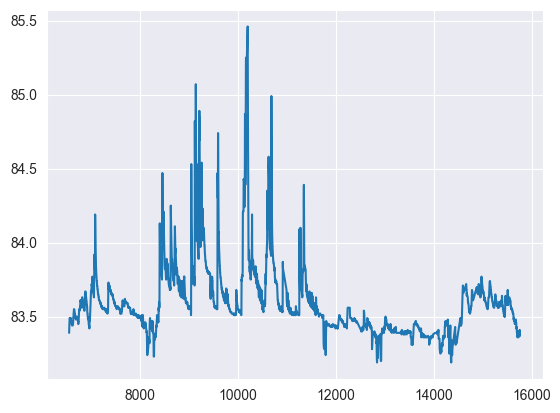

In [13]:
# data_copy.coeff.head(300).plot()
data_copy.waterlevels.plot()
# data_copy.waterlevels63000120.plot()
# data_copy.waterlevels63000100.plot()
# data_copy.waterlevels_smooth.plot()

In [37]:
data_copy.corr()


,temperature,humidity,windpower,rains,waterlevels63000120,rains63000100,waterlevels63000100,waterlevels,waterlevels_smooth
temperature,1.000000,-0.175283,0.199879,0.017164,0.232820,0.033081,0.736393,0.314363,0.314605
humidity,-0.175283,1.000000,-0.247311,0.132410,0.274553,0.123538,0.024634,0.300354,0.302486
windpower,0.199879,-0.247311,1.000000,0.017395,0.089733,0.029531,0.076236,0.053494,0.054493
rains,0.017164,0.132410,0.017395,1.000000,0.128359,0.636118,0.029454,0.137066,0.155693
waterlevels63000120,0.232820,0.274553,0.089733,0.128359,1.000000,0.164528,0.205819,0.871529,0.873812
rains63000100,0.033081,0.123538,0.029531,0.636118,0.164528,1.000000,0.035366,0.161185,0.178085
waterlevels63000100,0.736393,0.024634,0.076236,0.029454,0.205819,0.035366,1.000000,0.383711,0.383224
waterlevels,0.314363,0.300354,0.053494,0.137066,0.871529,0.161185,0.383711,1.000000,0.997950
waterlevels_smooth,0.314605,0.302486,0.054493,0.155693,0.873812,0.178085,0.383224,0.997950,1.000000


In [111]:
no_time_data = data.drop(columns=['times'])

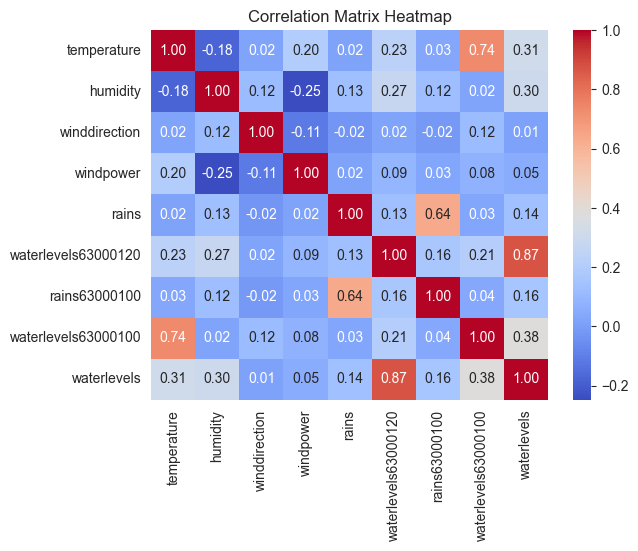

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
corr_matrix = no_time_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Correlation Matrix Heatmap")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import numpy as np
# 定义特征变量和目标变量
data_o = no_time_data.drop(columns=['winddirection'])
data_o - data_o.shift(-1)

,temperature,humidity,windpower,rains,waterlevels63000120,rains63000100,waterlevels63000100,waterlevels
6552,0.0,1.0,1.0,0.5,0.01,0.5,0.00,-0.02
6553,0.0,0.0,-1.0,0.0,0.00,0.0,0.01,-0.01
6554,-1.0,5.0,1.0,-0.5,0.00,0.0,0.00,-0.01
6555,1.0,-7.0,-1.0,0.0,0.00,0.0,0.00,-0.01
6556,0.0,0.0,-1.0,0.5,0.00,0.0,0.01,-0.01
...,...,...,...,...,...,...,...,...
15762,1.0,-9.0,-1.0,0.0,0.03,0.0,-0.01,0.00
15763,2.0,-9.0,-1.0,0.0,0.00,0.0,0.00,0.00
15764,3.0,5.0,1.0,0.0,0.00,0.0,0.00,-0.01
15765,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00


In [37]:
X, y = [],[]
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
data = x_scaler.fit_transform(data_o)
y_scaler.fit_transform(data_o['waterlevels'].values.reshape(-1, 1))
seq_len = 1
for i in range(len(data) - seq_len - 2):
    X.append(data[i:i+seq_len,:-1])  # 10 天特征
    y.append(data[i+seq_len,-1])  # 第 11 天水位
# print(X[0])
# print(y[0])
X, y = np.array(X), np.array(y)
X[:, -1] = np.sqrt(X[:, -1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# print(X.shape, y.shape)
# print(X_train.shape, X_test.shape)

<class 'numpy.ndarray'>
(7,)


np.float64(0.010662395065635618)

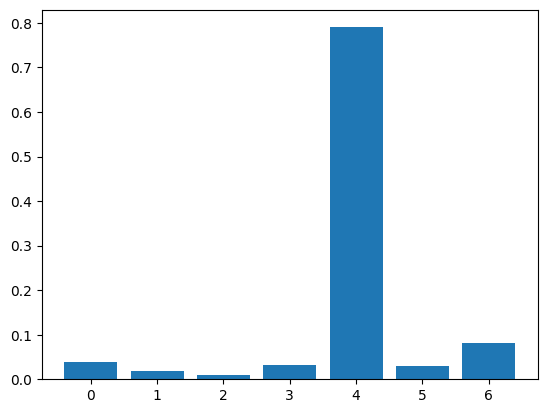

In [39]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
xgb_model = XGBRegressor(n_estimators=100)
# print(X_train.reshape(X_train.shape[0],-1).shape)
print(type(X_train))
xgb_model.fit(X_train.reshape(X_train.shape[0],-1), y_train)
y_pred = xgb_model.predict(X_train.reshape(X_train.shape[0], -1))
importance = xgb_model.feature_importances_
print(importance.shape)
plt.bar(range(importance.shape[0]),importance)
rmse = np.sqrt(mean_squared_error(y_pred, y_train))
rmse

In [291]:
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [292]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # 预测一个数值

    def forward(self, x):
        # print("Input shape:", x.shape)
        out, _ = self.lstm(x)  # out: (batch_size, seq_len, hidden_size)
        # print("LSTM output shape:", out.shape)
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        return out

In [293]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [294]:
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
x_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
# y_train = y_train.clone().detach().to(torch.float32).to(device)
# y_test = y_test.clone().detach().to(torch.float32).view(-1, 1).to(device)


train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

C:\Users\mengyonghao\AppData\Local\Temp\ipykernel_23188\2003608435.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
C:\Users\mengyonghao\AppData\Local\Temp\ipykernel_23188\2003608435.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).to(device)


In [295]:
epochs = 20
for epoch in range(epochs):
    for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 1, Loss: 0.0008
Epoch 2, Loss: 0.0007
Epoch 3, Loss: 0.0005
Epoch 4, Loss: 0.0005
Epoch 5, Loss: 0.0006
Epoch 6, Loss: 0.0006
Epoch 7, Loss: 0.0005
Epoch 8, Loss: 0.0005
Epoch 9, Loss: 0.0005
Epoch 10, Loss: 0.0005
Epoch 11, Loss: 0.0005
Epoch 12, Loss: 0.0004
Epoch 13, Loss: 0.0004
Epoch 14, Loss: 0.0003
Epoch 15, Loss: 0.0004
Epoch 16, Loss: 0.0003
Epoch 17, Loss: 0.0003
Epoch 18, Loss: 0.0003
Epoch 19, Loss: 0.0003
Epoch 20, Loss: 0.0002


In [263]:
model.eval()
y_preds = []
y_trues = []

with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch).squeeze()

        y_preds.extend(y_pred.cpu().numpy())
        y_trues.extend(y_batch.cpu().numpy())
print(y_preds[0])
print(y_trues[0])

0.06643373
0.07048458


In [264]:
y_preds = y_scaler.inverse_transform(np.array(y_preds).reshape(-1, 1))
y_trues = y_scaler.inverse_transform(np.array(y_trues).reshape(-1, 1))
print(y_preds[0])
print(y_trues[0])
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
print(f"测试集 RMSE: {rmse:.4f}")

[83.340805]
[83.350006]
测试集 RMSE: 0.0254


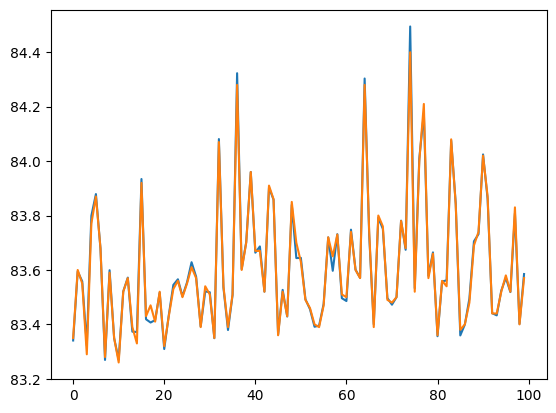

In [266]:
import matplotlib.pyplot as plt
plt.plot(range(100), y_preds[:100])
plt.plot(range(100), y_trues[:100])